In [1]:
import torch
from PIL import Image
import argparse
import os, json, random
import pandas as pd
import matplotlib.pyplot as plt
import glob, re
import random


from safetensors.torch import load_file
import matplotlib.image as mpimg
import copy
import gc
from transformers import CLIPTextModel, CLIPTokenizer

import diffusers
from diffusers import DiffusionPipeline
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, UNet2DConditionModel, LMSDiscreteScheduler
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor, AttentionProcessor


from typing import Optional, Union, Tuple, List, Callable, Dict
from tqdm.notebook import tqdm
from diffusers import StableDiffusionPipeline, DDIMScheduler
import torch.nn.functional as nnf
import numpy as np
import abc
import shutil
from torch.optim.adam import Adam

import ptp_utils as ptp_utils
from lora import LoRANetwork, DEFAULT_TARGET_REPLACE, UNET_TARGET_REPLACE_MODULE_CONV

from diffusers import DDIMScheduler, StableDiffusionPipeline
from hnull_inversion import NullInversion


In [2]:
### Config -------------------------
SD_MODEL = "/workspace/models/sd14"
LOW_RESOURCE = False 
NUM_DDIM_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
weight_dtype = torch.float32
device = torch.device('cuda')

scheduler = DDIMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,   
)


ldm_stable = StableDiffusionPipeline.from_pretrained(
    SD_MODEL,
    scheduler=scheduler,
    torch_dtype=weight_dtype
).to(device)

try:
    ldm_stable.disable_xformers_memory_efficient_attention()
except AttributeError:
    print("Attribute disable_xformers_memory_efficient_attention() is missing")

tokenizer = ldm_stable.tokenizer

# Null inversion
null_inversion = NullInversion(ldm_stable, guidance_scale = GUIDANCE_SCALE, device = device, num_ddim_steps = NUM_DDIM_STEPS)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

# Null Inversion to the capture image 

In [3]:
image_path = "/workspace/my_sliders/datasets/Different_hairline_db/arranged/rp0.png"
prompt = "real photograph of a male face"
(image_gt, image_enc), x_t, uncond_embeddings = null_inversion.invert(image_path, prompt, offsets=(0,0,0,0), verbose=True)

print("Modify or remove offsets according to your image!")

DDIM inversion...
Null-text optimization...


100%|██████████| 500/500 [00:56<00:00,  8.87it/s]

Modify or remove offsets according to your image!


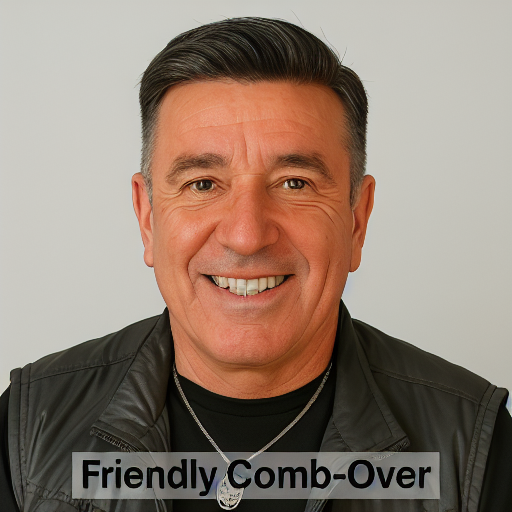

In [4]:
Image.fromarray(image_enc)

In [5]:
import copy
uncond_embeddings_copy = copy.deepcopy(uncond_embeddings)

In [6]:
def flush():
    torch.cuda.empty_cache()
    gc.collect()
flush()
width = 512
height = 512 
steps = NUM_DDIM_STEPS 
cfg_scale = GUIDANCE_SCALE

del ldm_stable
flush()

In [7]:
pretrained_model_name_or_path = SD_MODEL

revision = None
device = 'cuda'
rank = 8


# Load scheduler, tokenizer and models.
noise_scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False,    
                                steps_offset=1,   # <-- add this line
                               )
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path, subfolder="tokenizer", revision=revision
)
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder", revision=revision
)
vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder="vae", revision=revision)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet", revision=revision
)
# freeze parameters of models to save more memory
unet.requires_grad_(False)
unet.to(device, dtype=weight_dtype)
vae.requires_grad_(False)

text_encoder.requires_grad_(False)

# For mixed precision training we cast all non-trainable weigths (vae, non-lora text_encoder and non-lora unet) to half-precision
# as these weights are only used for inference, keeping weights in full precision is not required.


# Move unet, vae and text_encoder to device and cast to weight_dtype
vae.requires_grad_(False)
vae.to(device, dtype=weight_dtype)
text_encoder.to(device, dtype=weight_dtype)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [8]:
slider1 = "/workspace/my_sliders/models/'bangslider'_alpha1.0_rank8_noxattn/'bangslider'_alpha1.0_rank8_noxattn_last.pt"

train_method = 'noxattn'
network_type = "c3lier"
if train_method == 'xattn':
    network_type = 'lierla'

modules = DEFAULT_TARGET_REPLACE
if network_type == "c3lier":
    modules += UNET_TARGET_REPLACE_MODULE_CONV
import os
model_name = slider1

name = os.path.basename(model_name)
alpha = 1.0
# freeze parameters of models to save more memory
unet.requires_grad_(False)
unet.to(device, dtype=weight_dtype)
network1 = LoRANetwork(
        unet,
        rank=rank,
        multiplier=1.0,
        alpha=alpha,
        train_method=train_method,
    ).to(device, dtype=weight_dtype)
network1.load_state_dict(torch.load(slider1))

torch_device = device
negative_prompt = None
batch_size = 1
height = 512
width = 512
ddim_steps = NUM_DDIM_STEPS
guidance_scale = GUIDANCE_SCALE

create LoRA for U-Net: 150 modules.


  0%|          | 0/50 [00:00<?, ?it/s]

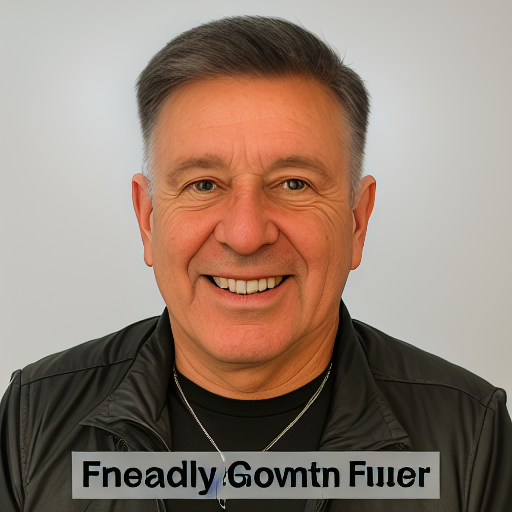

  0%|          | 0/50 [00:00<?, ?it/s]

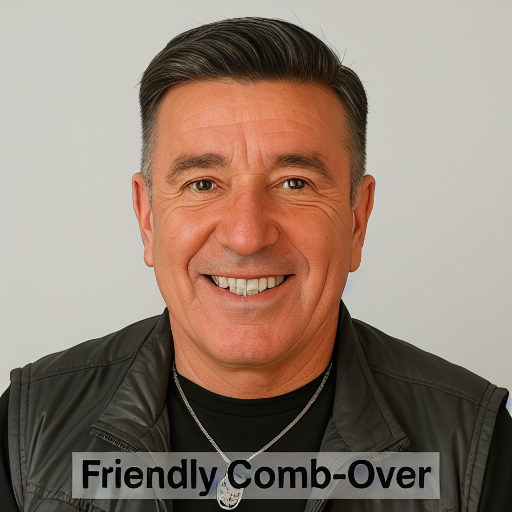

  0%|          | 0/50 [00:00<?, ?it/s]

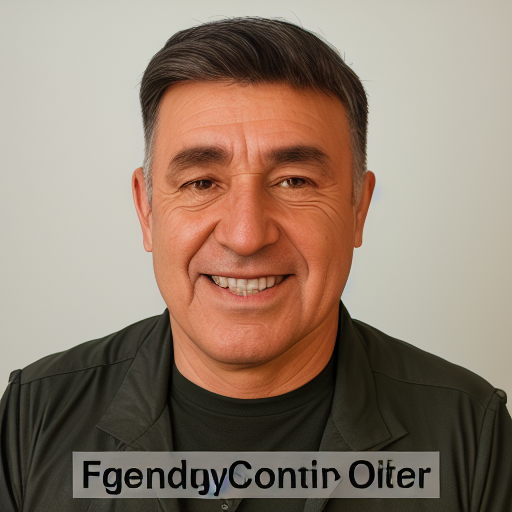

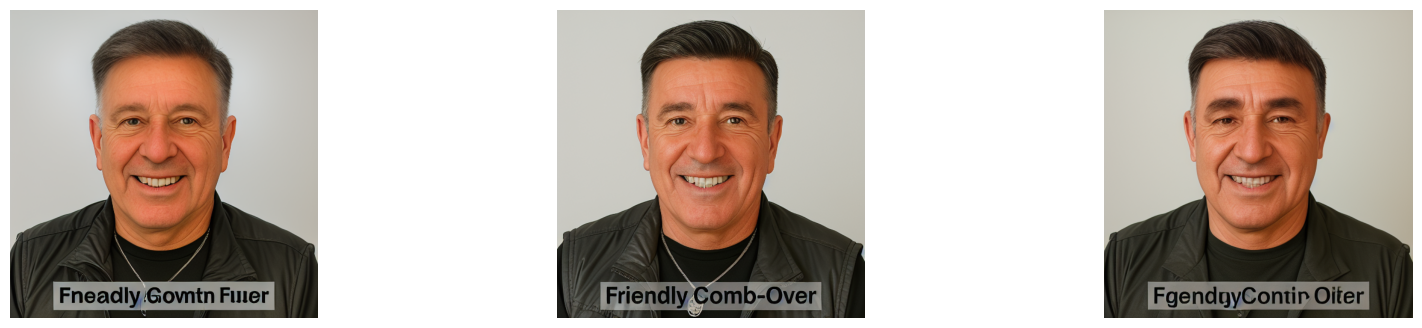

In [9]:
scales1 = [-1,0, 1]
start_noise = 700 # use smaller values for real image editing so that the identity does not change

images_list = []
for scale1 in scales1:
    
   
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

    text_embeddings_ = text_encoder(text_input.input_ids.to(torch_device))[0]

    max_length = text_input.input_ids.shape[-1]

    noise_scheduler.set_timesteps(ddim_steps)


    latents = x_t* noise_scheduler.init_noise_sigma
    latents = latents.to(unet.dtype)
    cnt = -1
    for t in tqdm(noise_scheduler.timesteps):
        cnt+=1
        if t>start_noise:
            network1.set_lora_slider(scale=0)
        else:
            network1.set_lora_slider(scale=scale1)
        
        text_embeddings = torch.cat([uncond_embeddings_copy[cnt].expand(*text_embeddings_.shape), text_embeddings_])
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        text_embeddings = text_embeddings.to(weight_dtype)
        latent_model_input = noise_scheduler.scale_model_input(latent_model_input, timestep=t)
        # predict the noise residual
        
        with torch.no_grad():
            with network1:
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = noise_scheduler.step(noise_pred, t, latents).prev_sample

    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).to(torch.float16).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    images_list.append(pil_images[0])
    display(pil_images[0])

fig, ax = plt.subplots(1, len(images_list), figsize=(20,4))
for i, a in enumerate(ax):
    a.imshow(images_list[i])
    a.axis('off')


plt.show()

# for im in images_list:
#     display(im)